In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
signal_trees_no_pu = ObjIter(list(map(Tree,fc.eightb.accstudies.raw_no_pu.signal_list)))
signal_trees = ObjIter(list(map(Tree,fc.eightb.accstudies.raw_with_pu.signal_list)))

# signal_trees.extend(kwargs=lambda tree : dict(n_ext_jet=tree.n_jet-tree.nfound_presel))
# signal_trees.extend(kwargs=eightb.reco_all)
# signal_trees.extend(kwargs=eightb.reco_res_all)

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


In [3]:
def get_point(label):
    label = label.split('_')
    return str((int(label[1]),int(label[3])))
signal_points = list(map(get_point,signal_trees.sample))

In [4]:
dout = "gen_studies/recojets/"

In [5]:
ylist = [
    f'gen_{y}'
    for y in ('Y1','Y2')
]

higgslist = [
    f'gen_{h}{y}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
]


quarklist = [
    f'gen_{h}{y}_{b}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
    for b in ('b1','b2')
]

In [6]:
def make_recojet_variables(tree):
    recojets = ak.zip({
        var: ak.concatenate([tree[f'{quark}_recojet_{var}'][:, None]
                            for quark in quarklist], axis=-1)
        for var in ('pt','ptRegressed', 'eta', 'phi', 'm')
    })
    
    genjets = ak.zip({
        var: ak.concatenate([tree[f'{quark}_genjet_{var}'][:, None]
                            for quark in quarklist], axis=-1)
        for var in ('pt', 'eta', 'phi', 'm')
    })
    
    recojet_matched = 1*(recojets.pt>0)
    
    gen_var = dict(ptRegressed='pt')
    
    tree.extend(
        **{
            f'gen_{quark}_id': i*ak.ones_like(tree.Run)
            for i, quark in enumerate(eightb.quarklist)
        },
        **{
            f'{quark}_recojet_genjet_matched': recojet_matched[:,i]
            for i,quark in enumerate(quarklist)
        },
        **{
            f'{quark}_recojet_{var}_res': (recojets[var]/genjets[gen_var.get(var,var)])[:,i]
            for i,quark in enumerate(quarklist)
            for var in ('pt', 'ptRegressed', 'eta', 'phi',)
        },
        **{
            f'{quark}_recojet_pt_regression': (recojets.ptRegressed/recojets.pt)[:,i]
            for i,quark in enumerate(quarklist)
        },
    )

In [7]:
signal_trees.apply(make_recojet_variables)
signal_trees.apply(eightb.make_genjet_variables)
signal_trees.apply(lambda t : build_collection(t,'gen_H\dY\d_b\d','gen_quark', ordered='recojet_ptRegressed'))


[None, None, None]

In [8]:
signal_trees_no_pu.apply(make_recojet_variables)
signal_trees_no_pu.apply(eightb.make_genjet_variables)
signal_trees_no_pu.apply(lambda t : build_collection(t,'gen_H\dY\d_b\d','gen_quark', ordered='recojet_ptRegressed'))


[None, None, None]

In [9]:
varinfo.nfound_all = dict(xlabel="N Higgs Jets")

100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


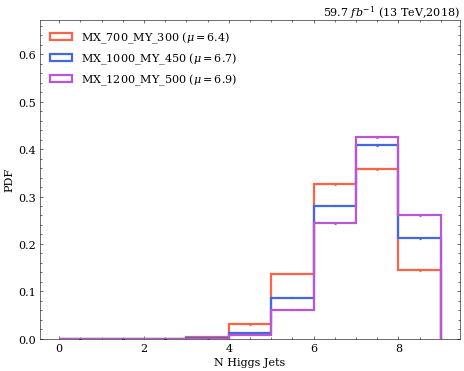

In [10]:
study.quick( 
    signal_trees, legend=True,
    h_label_stat='mean',
    varlist=['nfound_all'],
    efficiency=True,
    saveas=f"{dout}/n_higgs_jets"
)

100%|██████████| 4/4 [00:00<00:00, 15.59it/s]


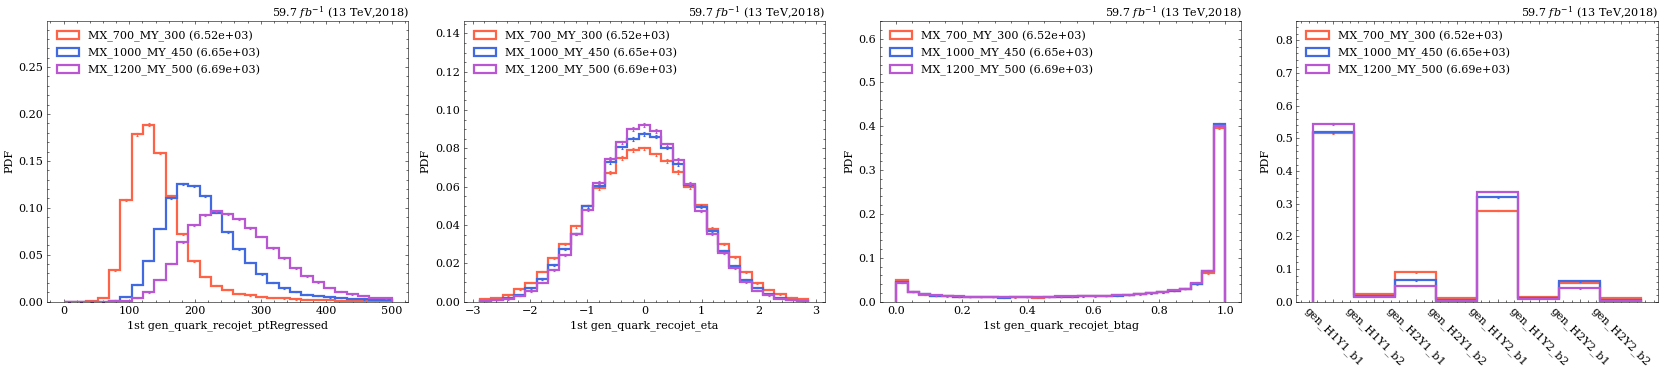

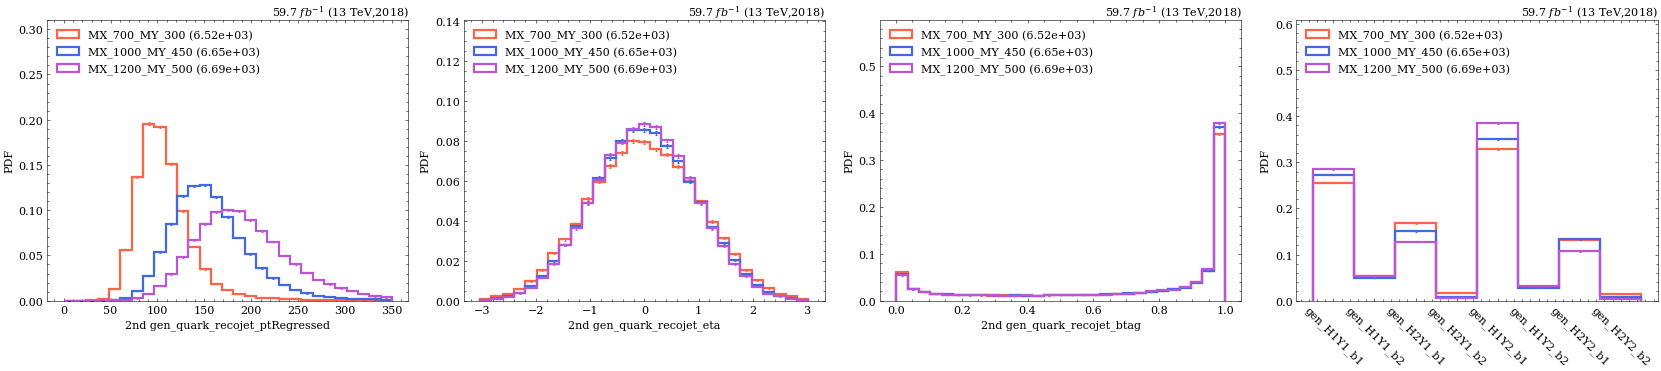

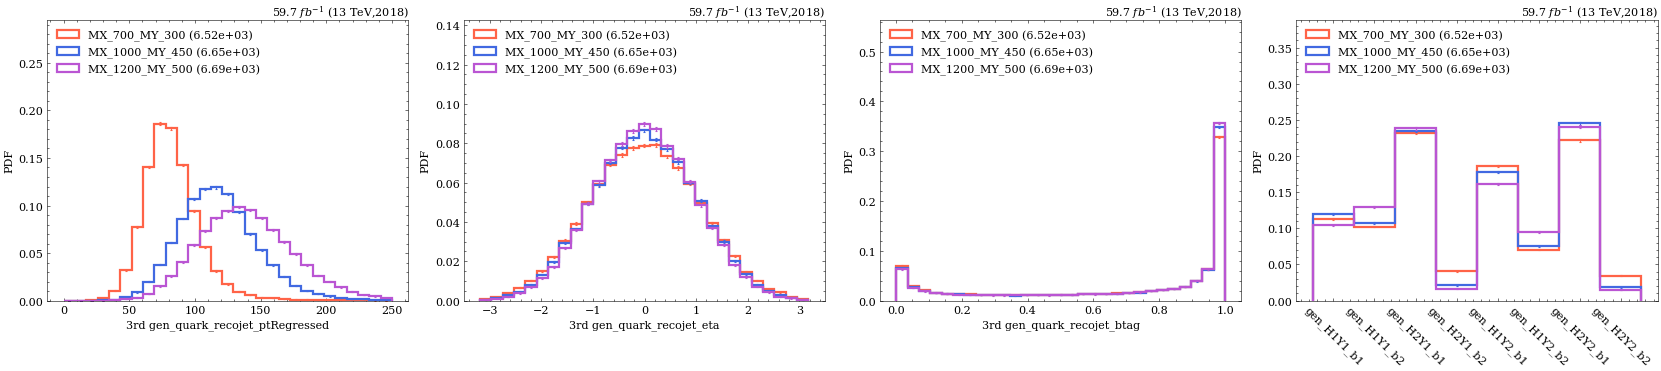

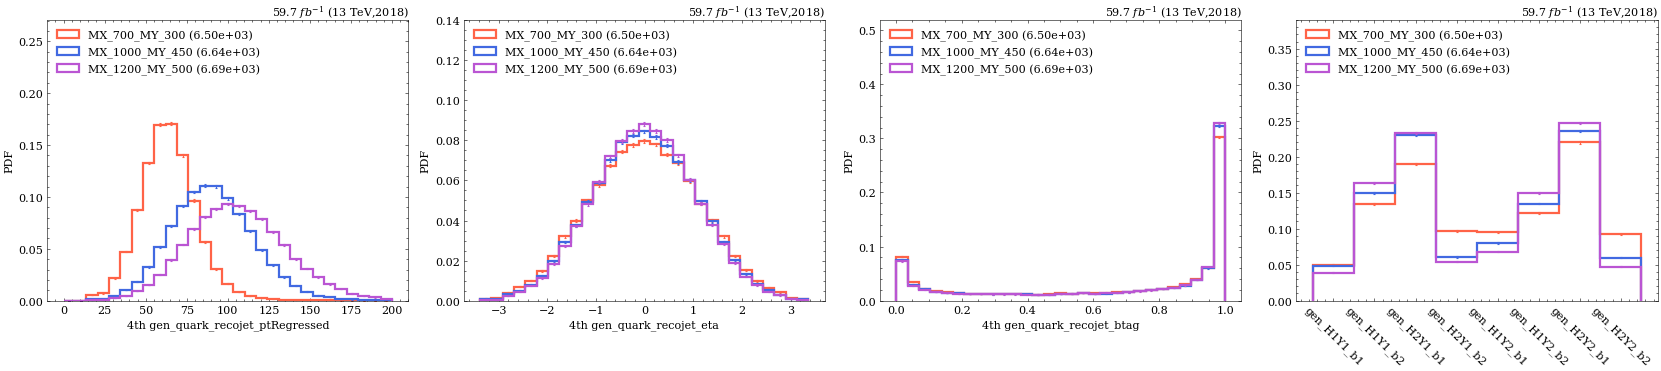

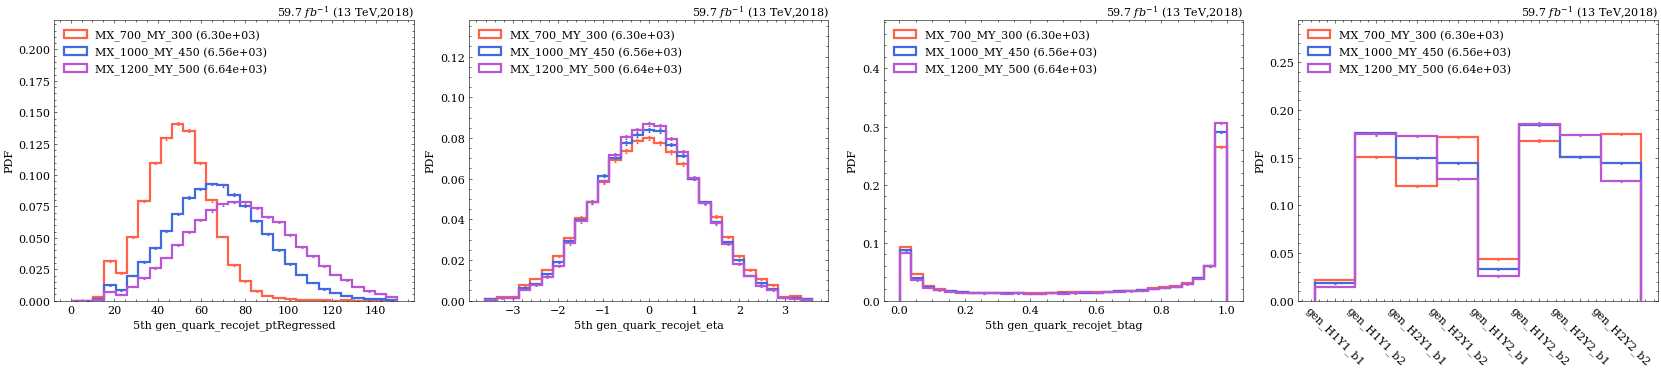

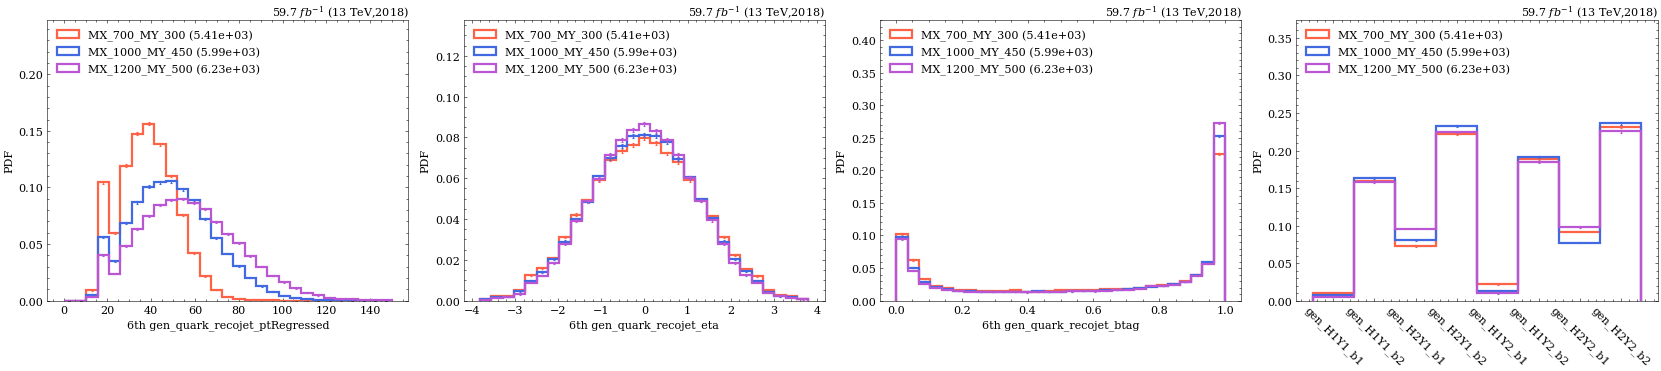

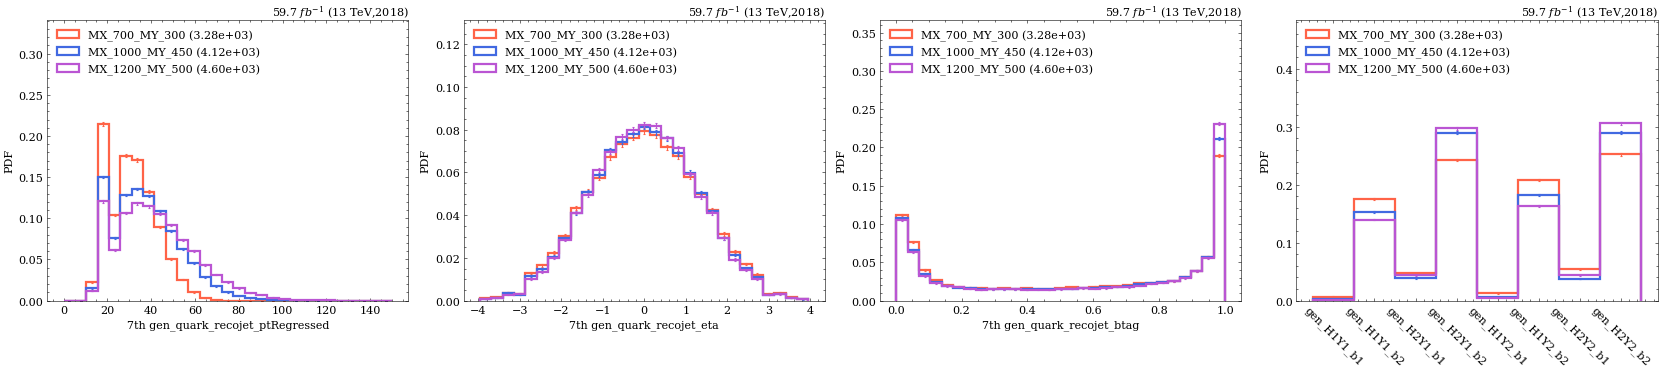

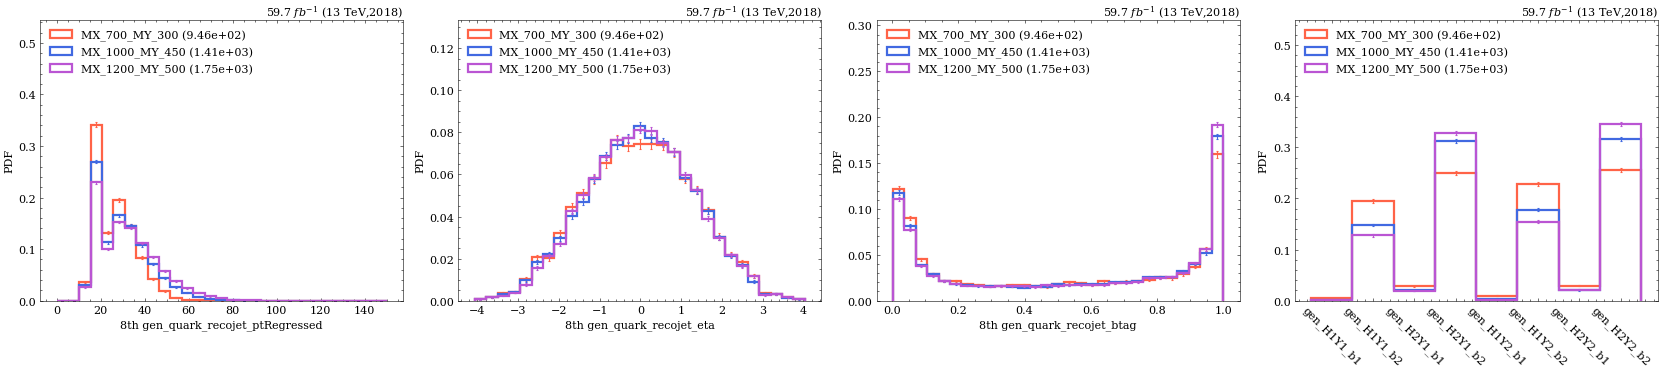

In [11]:
varlist = ['recojet_ptRegressed','recojet_eta','recojet_btag','id']

varinfo.gen_quark_id = dict(xlabel=[f"gen_{quark}" for quark in eightb.quarklist], bins=np.arange(9))

ptmax_ = [500,350,250,200,150,150,150,150]

for i,quark in enumerate(quarklist):
    ptmax = ptmax_[i]
    study.quick(
        signal_trees, legend=True,
        masks=lambda t : t.gen_quark_recojet_pt[:,i]>0,
        varlist=[f'gen_quark_{var}[:,{i}]' for var in varlist],
        efficiency=True,
        binlist=[(0,ptmax,30)],
        dim=(-1,len(varlist)),
        saveas=f'{dout}/{ordinal(i)}_pt_reco_jet'
    )

In [12]:
trigger = 'HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5'

trigger_selection = EventFilter('trigger', **{trigger:1})

signal_trees = signal_trees.apply(trigger_selection)
signal_trees_no_pu = signal_trees_no_pu.apply(trigger_selection)

100%|██████████| 1/1 [00:00<00:00,  6.46it/s]


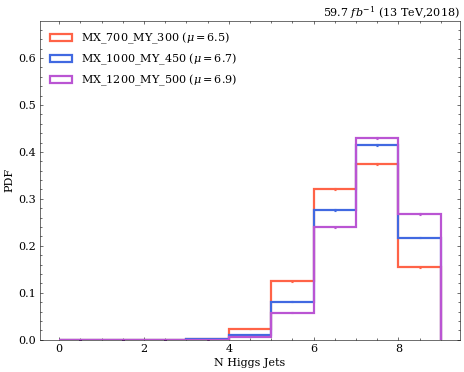

In [13]:
study.quick( 
    signal_trees, legend=True,
    h_label_stat='mean',
    varlist=['nfound_all'],
    efficiency=True,
    saveas=f"{dout}/trigger/n_higgs_jets"
)

100%|██████████| 4/4 [00:00<00:00, 15.17it/s]


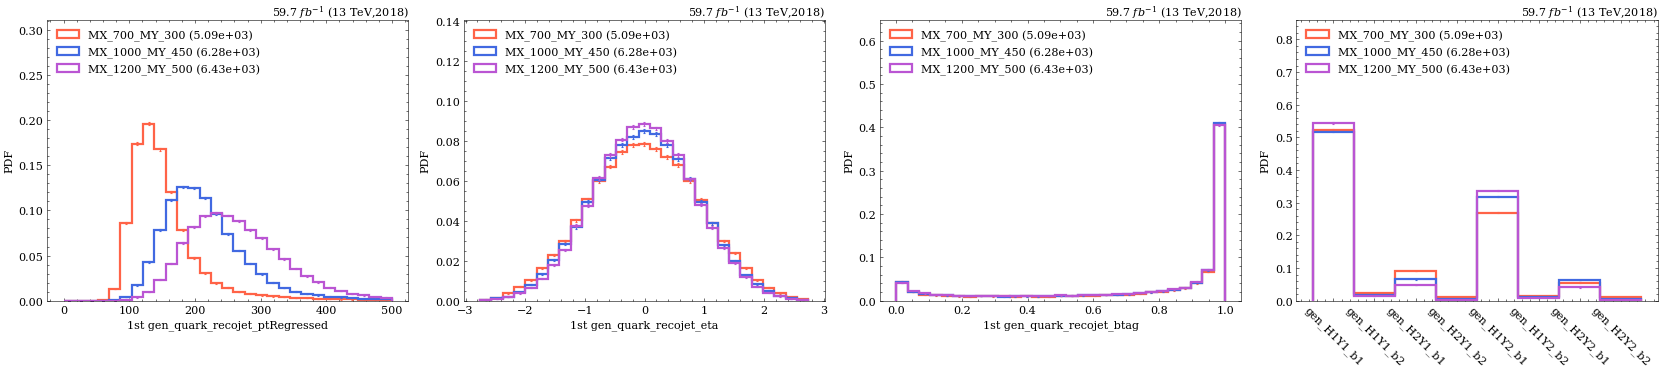

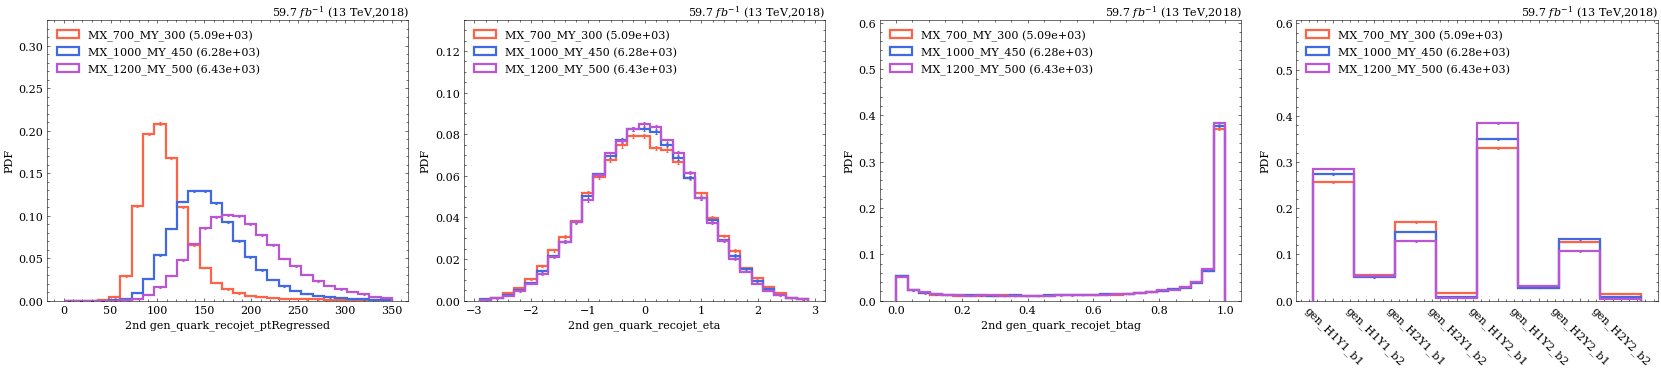

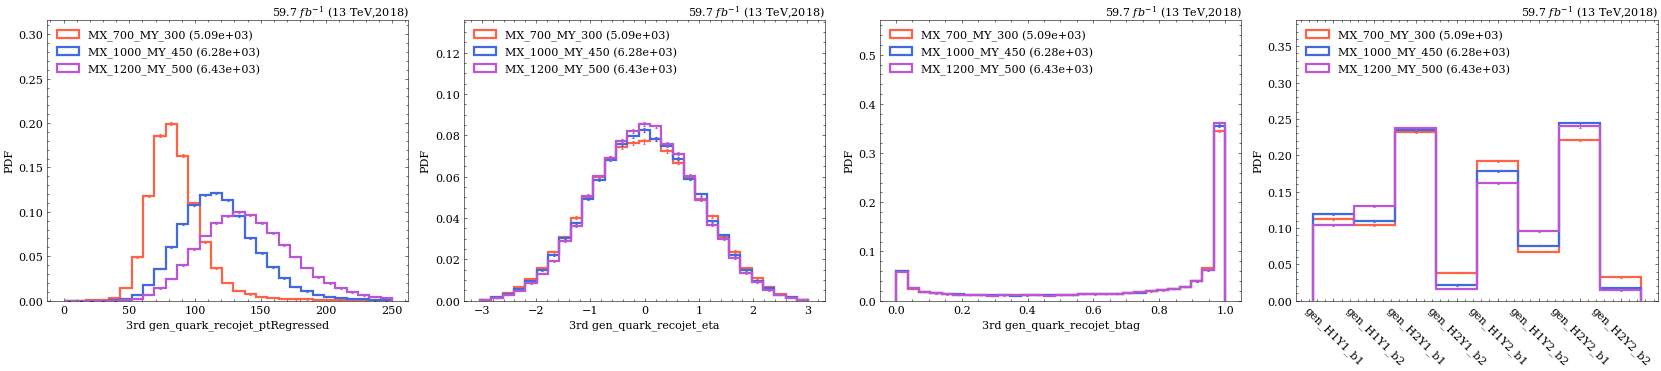

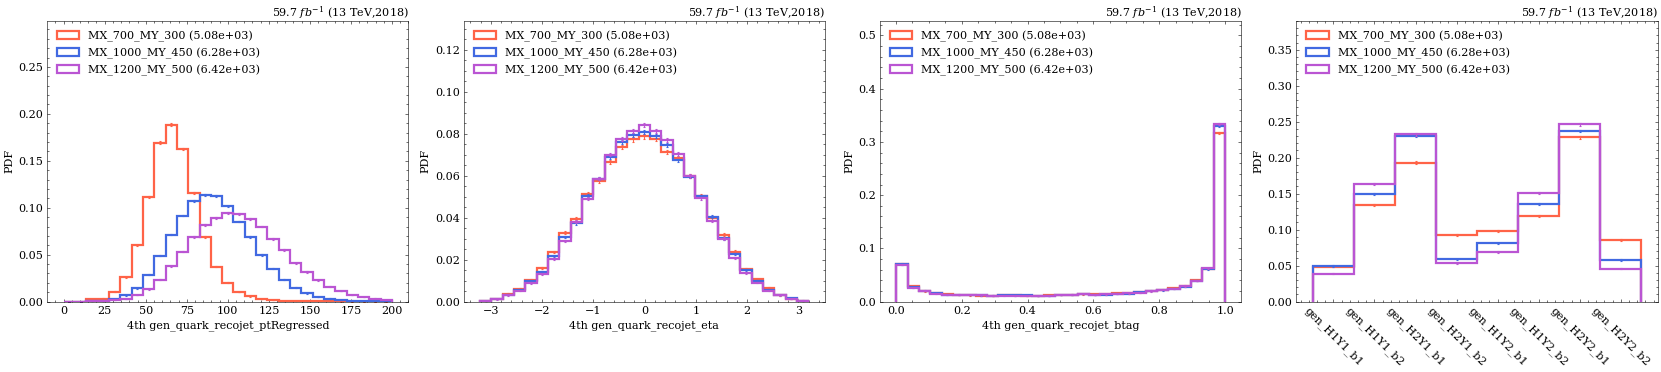

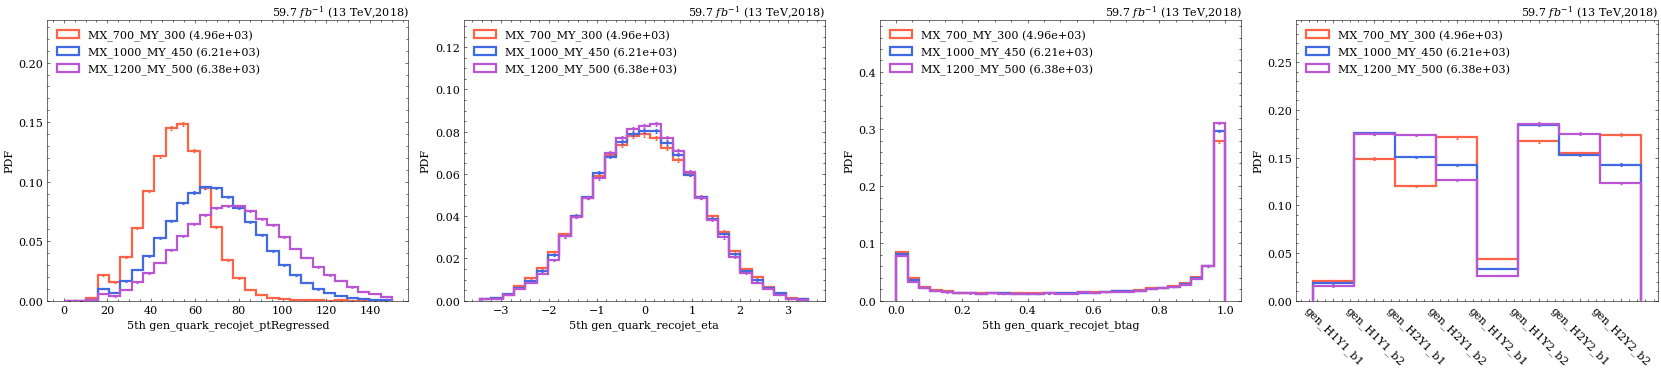

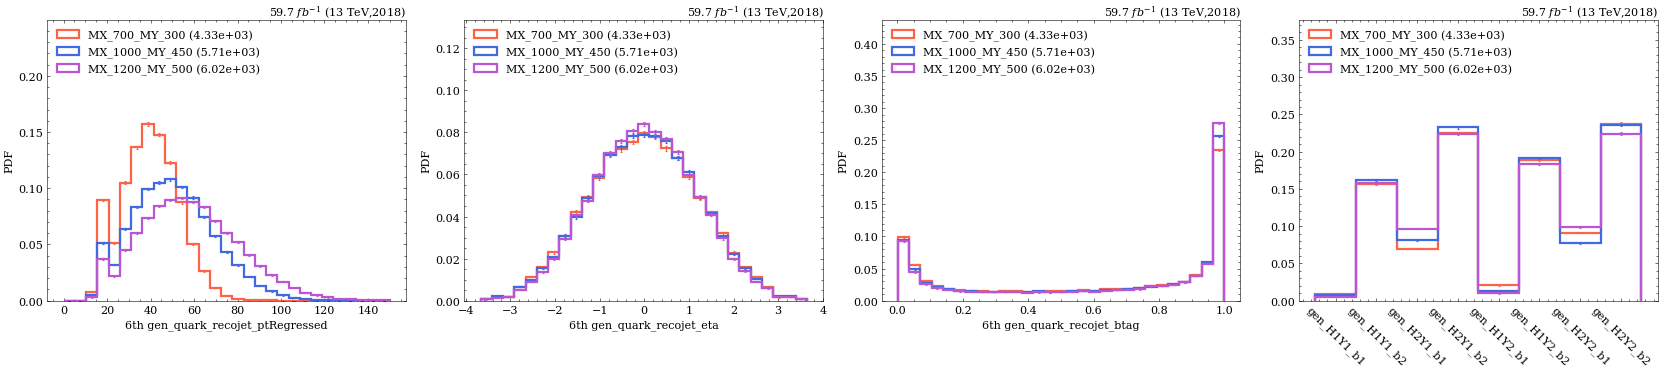

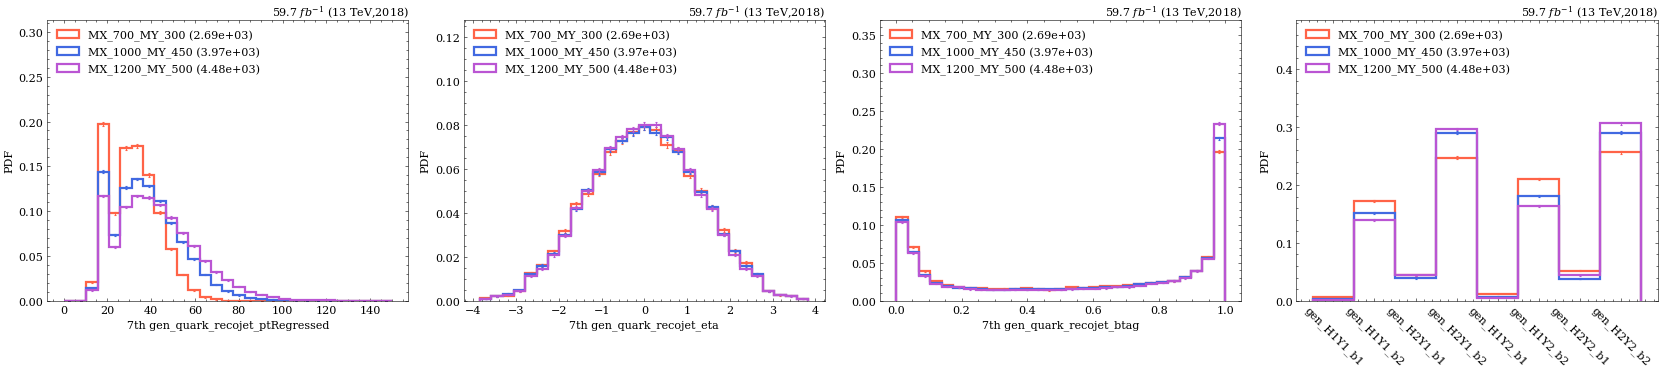

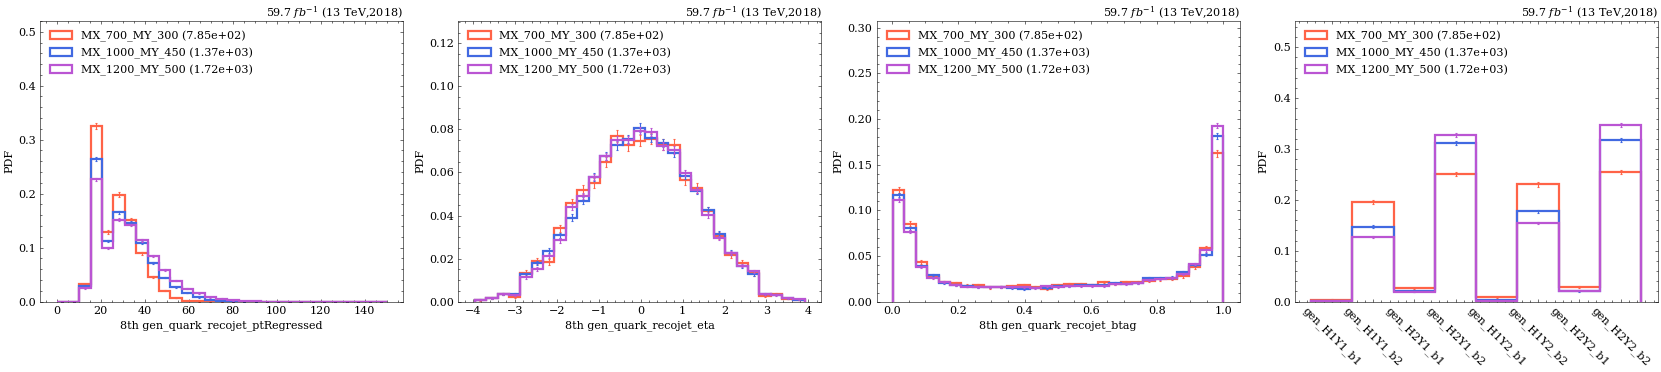

In [14]:
varlist = ['recojet_ptRegressed','recojet_eta','recojet_btag','id']

varinfo.gen_quark_id = dict(xlabel=[f"gen_{quark}" for quark in eightb.quarklist], bins=np.arange(9))

ptmax_ = [500,350,250,200,150,150,150,150]

for i,quark in enumerate(quarklist):
    ptmax = ptmax_[i]
    study.quick(
        signal_trees, legend=True,
        masks=lambda t : t.gen_quark_recojet_pt[:,i]>0,
        varlist=[f'gen_quark_{var}[:,{i}]' for var in varlist],
        efficiency=True,
        binlist=[(0,ptmax,30)],
        dim=(-1,len(varlist)),
        saveas=f'{dout}/trigger/{ordinal(i)}_pt_reco_jet'
    )

In [15]:
def require_recojets(t):
    recojet_pt = t.gen_quark_recojet_pt
    recojet_eta = t.gen_quark_recojet_eta
    gen_quark_recojet_pt20=(recojet_pt > 20)
    gen_quark_recojet_eta25=(np.abs(recojet_eta)<2.5)
    gen_quark_recojet_pt20eta25 = gen_quark_recojet_pt20 & gen_quark_recojet_eta25
    t.extend(
        gen_quark_recojet_pt20=gen_quark_recojet_pt20,
        gen_quark_recojet_eta25=gen_quark_recojet_eta25,
        gen_quark_recojet_pt20eta25=gen_quark_recojet_pt20eta25,
        
        n_gen_quark_recojet_pt20=ak.sum(gen_quark_recojet_pt20,axis=-1),
        n_gen_quark_recojet_eta25=ak.sum(gen_quark_recojet_eta25,axis=-1),
        n_gen_quark_recojet_pt20eta25=ak.sum(gen_quark_recojet_pt20eta25,axis=-1),
    )
signal_trees.apply(require_recojets)
signal_trees_no_pu.apply(require_recojets)


[None, None, None]

100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


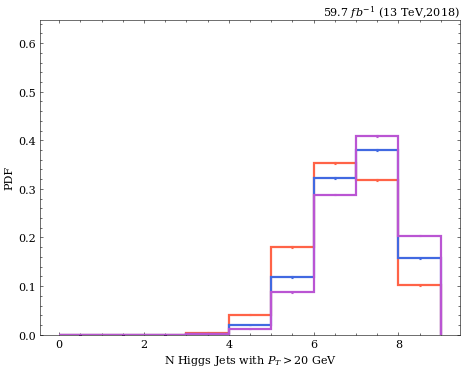

In [16]:
study.quick( 
    signal_trees,
    efficiency=True,
    varlist=['n_gen_quark_recojet_pt20'],
    xlabels=['N Higgs Jets with $P_{T}>20$ GeV'],
    saveas=f"{dout}/trigger/n_higgs_jets_pt20"
)

100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


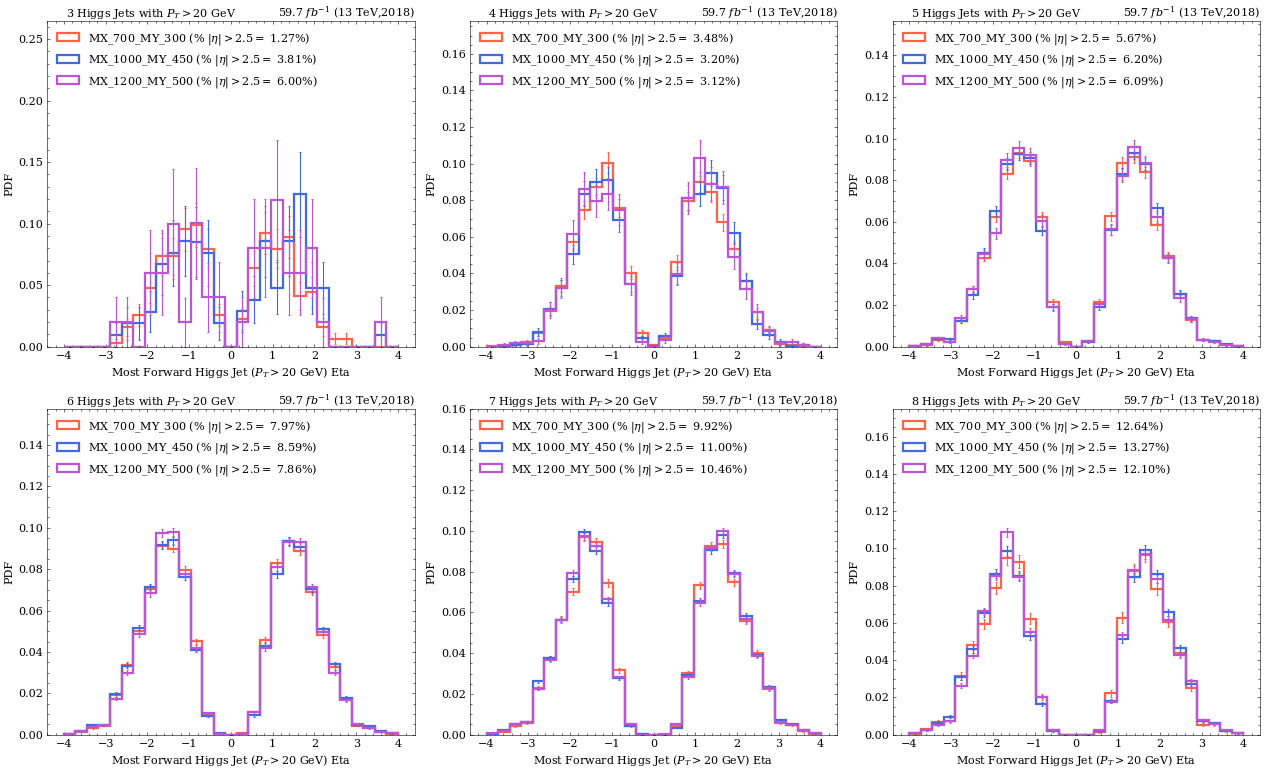

In [17]:
def most_forward_gen_quark_recojet_eta(t):
    matched_recojet_eta = t.gen_quark_recojet_eta[t.gen_quark_recojet_pt20]
    argmax = ak.argmax( np.abs(matched_recojet_eta), axis=-1, keepdims=True)
    return matched_recojet_eta[argmax]

M = np.arange(3,9)

fig, axs = study.get_figax(nvar=len(M))
for i, m in enumerate(M):
    study.quick(
        signal_trees, legend=True,
        h_label_stat=lambda h: f"% $|\eta| > 2.5 =$ {np.mean(np.abs(h.array)>2.5):0.2%}",
        masks=lambda t:t.n_gen_quark_recojet_pt20==m,
        varlist=[most_forward_gen_quark_recojet_eta],
        xlabels=['Most Forward Higgs Jet ($P_{T}>20$ GeV) Eta'],
        binlist=[(-4,4,30),(-4,4,30)],
        efficiency=True,
        text=(0.05,1.02,f'{m} Higgs Jets with $P_{{T}}>20$ GeV'),
        figax=(fig, axs.flat[i])
    )
study.save_fig(fig, saveas=f'{dout}/trigger/most_forward_higgs_jet_eta')

100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


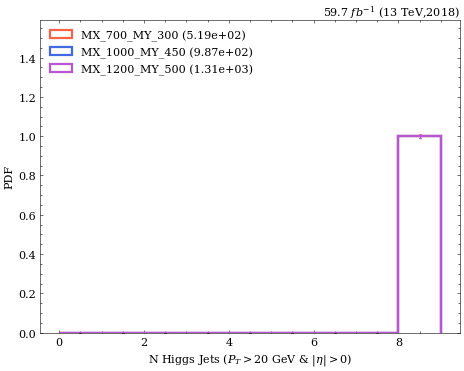

In [18]:
class n_higgs_jets(ObjTransform):
    @property
    def xlabel(self): return f'N Higgs Jets ($P_{{T}}>20$ GeV & $|\eta| > {self.eta}$)'
    def __call__(self, t):
        return ak.sum(np.abs(t.gen_quark_recojet_eta)>self.eta,axis=-1)

study.quick(
        signal_trees, legend=True,
        masks=lambda t:t.n_gen_quark_recojet_pt20==8,
        varlist=[n_higgs_jets(eta=0)],
        efficiency=True,
    )

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

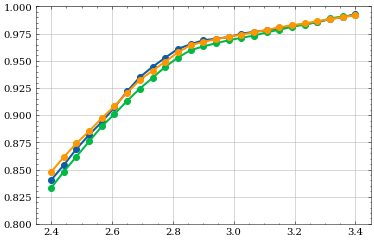

In [19]:
etas = np.linspace(2.4,3.4, 25)
def sweep_eta(t, etas=etas):
    mask = t.n_gen_quark_recojet_pt20==8
    fractions = [ak.mean(n_higgs_jets(eta=eta)(t)[mask]==0) for eta in etas]
    return np.array(fractions)

graph_arrays(etas, signal_trees.apply(sweep_eta).list, ylim=(0.8,1.0), grid=True)

In [86]:
def mask_good_recojet(t, ptcut=20, etacut=2.8):
    pt = t.gen_quark_recojet_ptRegressed
    eta = t.gen_quark_recojet_eta
    mask = (pt > ptcut) & (np.abs(eta) < etacut)
    return mask

In [129]:
class recojet_pt_sweep(ObjTransform):
    def __call__(self, t):
        mask = mask_good_recojet(t)
        recojet_pt = t.gen_quark_recojet_ptRegressed * mask - 999*(~mask)
        efficiency = np.array([ ak.mean( recojet_pt[:, self.i] > pt) for pt in self.sweep_pt ])
        return efficiency

class recojet_btag_sweep(ObjTransform):
    def __call__(self, t):
        mask = mask_good_recojet(t, etacut=self.etacut)
        recojet_btag = t.gen_quark_recojet_btag * mask - 999*(~mask)
        recojet_btag = ak.sort(recojet_btag, axis=-1, ascending=False)[:,self.i]

        if self.require:
            recojet_btag = recojet_btag[recojet_btag >= 0]

        efficiency = np.array([ ak.mean( recojet_btag > btag) for btag in self.sweep_btag ])
        return efficiency


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

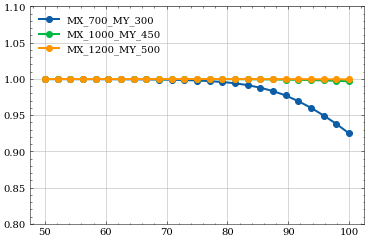

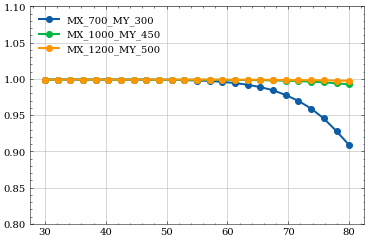

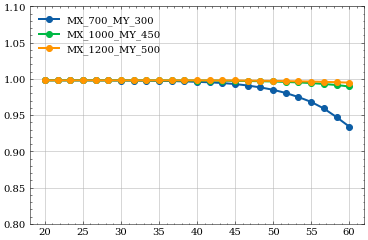

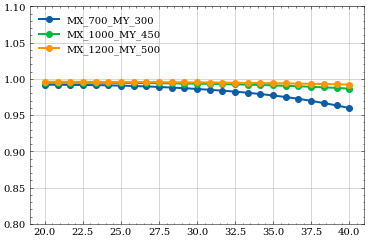

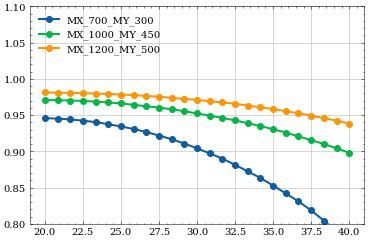

In [116]:
sweep_pt = np.linspace(50, 100, 25)
graph_arrays(sweep_pt, signal_trees.apply(recojet_pt_sweep(sweep_pt=sweep_pt, i=0)).list, ylim=(0.8,1.1), g_label=signal_trees.sample.list, legend=True, grid=True)
sweep_pt = np.linspace(30, 80, 25)
graph_arrays(sweep_pt, signal_trees.apply(recojet_pt_sweep(sweep_pt=sweep_pt, i=1)).list, ylim=(0.8,1.1), g_label=signal_trees.sample.list, legend=True, grid=True)
sweep_pt = np.linspace(20, 60, 25)
graph_arrays(sweep_pt, signal_trees.apply(recojet_pt_sweep(sweep_pt=sweep_pt, i=2)).list, ylim=(0.8,1.1), g_label=signal_trees.sample.list, legend=True, grid=True)
sweep_pt = np.linspace(20, 40, 25)
graph_arrays(sweep_pt, signal_trees.apply(recojet_pt_sweep(sweep_pt=sweep_pt, i=3)).list, ylim=(0.8,1.1), g_label=signal_trees.sample.list, legend=True, grid=True)
sweep_pt = np.linspace(20, 40, 25)
graph_arrays(sweep_pt, signal_trees.apply(recojet_pt_sweep(sweep_pt=sweep_pt, i=4)).list, ylim=(0.8,1.1), g_label=signal_trees.sample.list, legend=True, grid=True)

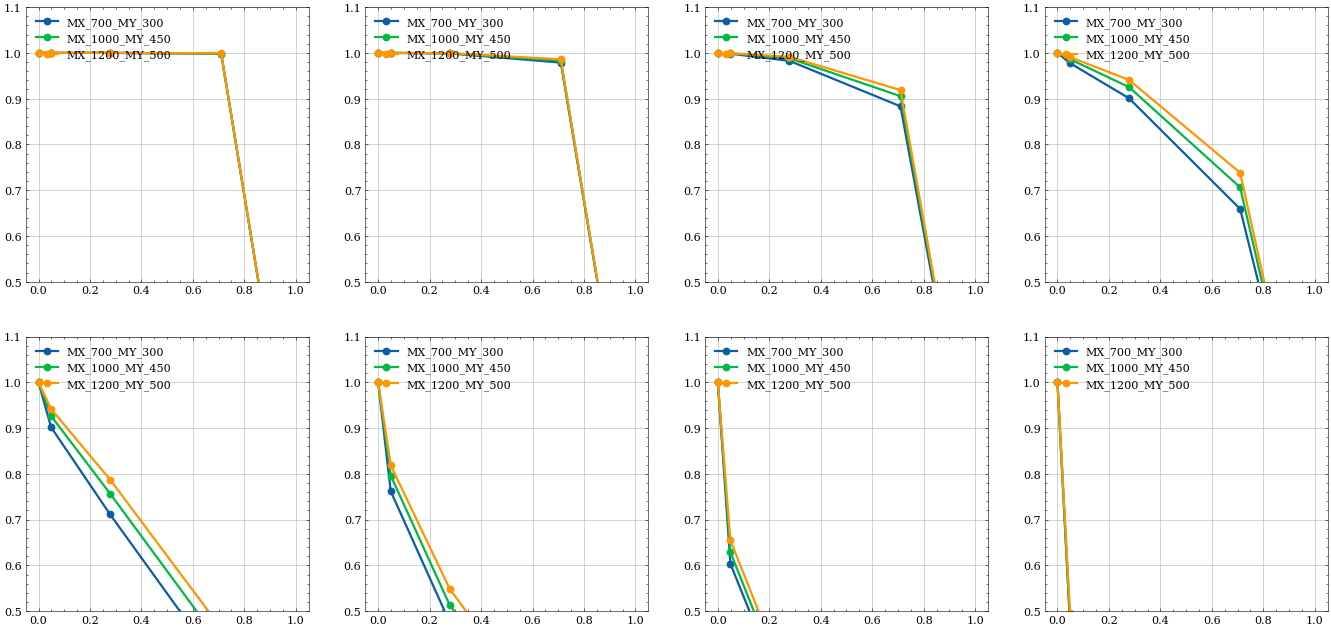

In [130]:
sweep_btag = jet_btagWP

fig, axs = study.get_figax(nvar=8)
for i in range(8):
    graph_arrays(
        sweep_btag, 
        signal_trees.apply(recojet_btag_sweep(sweep_btag=sweep_btag, i=i, etacut=2.5, require=True)).list, 
        ylim=(0.5,1.1), 
        g_label=signal_trees.sample.list, 
        legend=True, grid=True,
        figax=(fig,axs.flat[i]))


In [131]:
def gen_quark_btag_multi(t):
    mask = mask_good_recojet(t, etacut=2.5)
    btag = t.gen_quark_recojet_btag * mask - 999*(~mask)

    btagmulti = {
        f"n_gen_quark_{wplabel}_btag": ak.sum( btag > wp, axis=-1) for wp, wplabel in zip(jet_btagWP[:-1], wplabels)
    }
    t.extend(**btagmulti)
signal_trees.apply(gen_quark_btag_multi)

[None, None, None]

100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


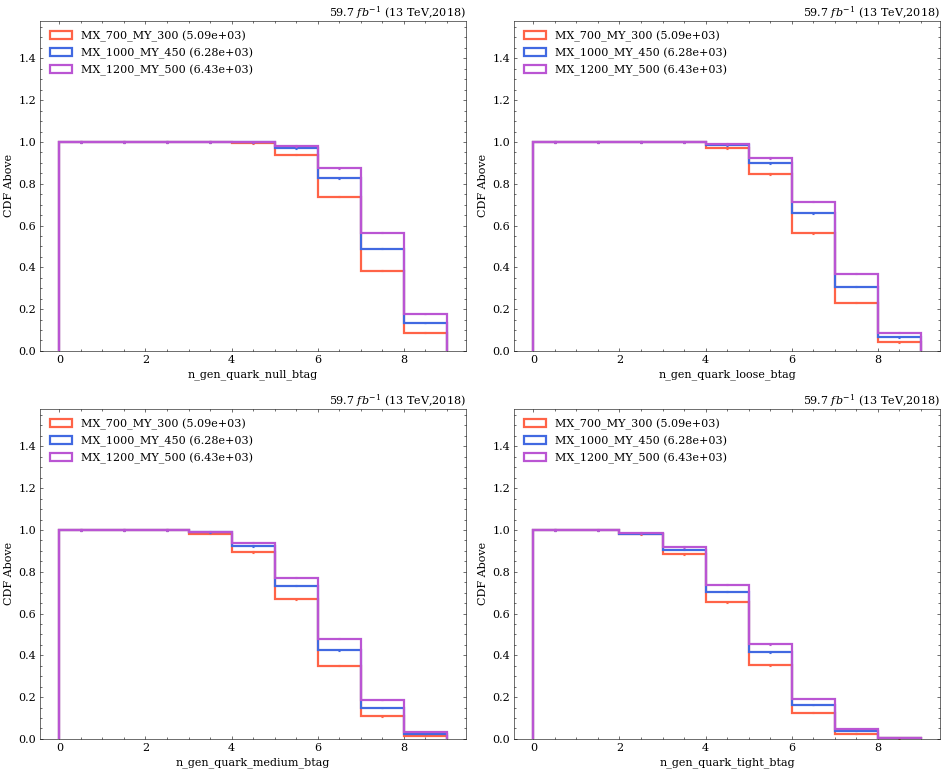

In [138]:
study.quick(
    signal_trees, legend=True,
    varlist=[f"n_gen_quark_{wplabel}_btag" for wplabel in wplabels],
    efficiency=True,
    cumulative=-1,
)

100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


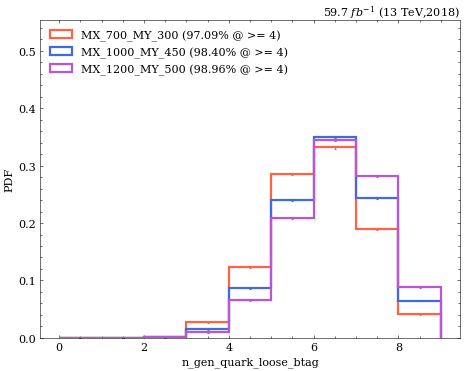

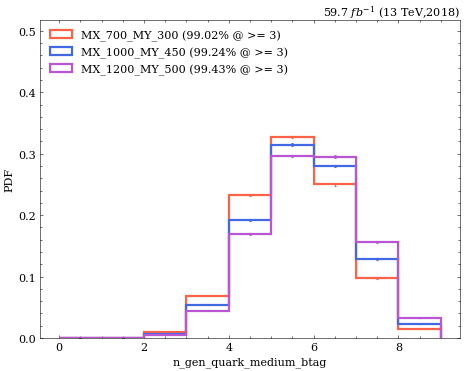

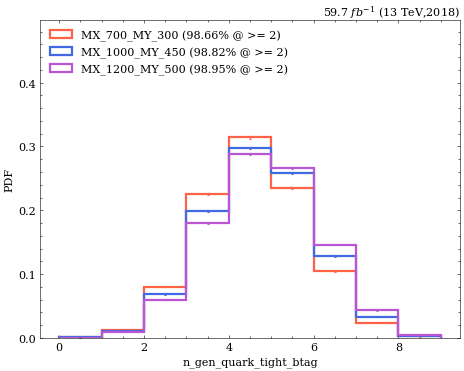

In [147]:
study.quick(
    signal_trees, legend=True,
    h_label_stat=lambda h: f"{np.mean(np.abs(h.array)>=4):0.2%} @ >= 4",
    varlist=[f"n_gen_quark_loose_btag"],
    efficiency=True,
)

study.quick(
    signal_trees, legend=True,
    masks=lambda t:t.n_gen_quark_loose_btag>=4,
    h_label_stat=lambda h: f"{np.mean(np.abs(h.array)>=3):0.2%} @ >= 3",
    varlist=[f"n_gen_quark_medium_btag"],
    efficiency=True,
)

study.quick(
    signal_trees, legend=True,
    masks=lambda t:(t.n_gen_quark_loose_btag>=4)&(t.n_gen_quark_medium_btag>=3),
    h_label_stat=lambda h: f"{np.mean(np.abs(h.array)>=2):0.2%} @ >= 2",
    varlist=[f"n_gen_quark_tight_btag"],
    efficiency=True,
)

In [152]:
def select_jet_ptcut(t, ptcuts=[80, 60, 45, 30]):
    jet_pt = t.jet_ptRegressed
    jet_pt = ak.sort(jet_pt, axis=-1, ascending=False)
    mask = jet_pt[:,0] > 0
    for i, ptcut in enumerate(ptcuts):
        mask = mask &  (jet_pt[:,i]>ptcut)
    return mask

select_jet_ptcut = EventFilter(
    "select_jet_ptcut",
    filter = select_jet_ptcut
)

In [153]:
def select_jet_btagmulti(t, btagmulti=[4, 3, 2]):
    btag = t.jet_btag
    mask = btag[:,0] >= 0
    for wp, multi in zip(jet_btagWP[1:-1], btagmulti):
        n_btag = ak.sum(btag > wp, axis=-1)
        mask = mask & (n_btag >= multi)
    return mask

select_jet_btagmulti = EventFilter(
    "select_jet_btagmulti",
    filter = select_jet_btagmulti
)

In [158]:
module = fc.eightb.preselection.t8btag_minmass
signal = ObjIter([ Tree(f) for f in module.signal_list ])
bkg = ObjIter([ Tree(module.QCD_B_List), Tree(module.TTJets)])

100%|██████████| 2/2 [00:05<00:00,  2.94s/it]


In [159]:
(signal + bkg).apply(lambda t:build_collection(t, 'H\dY\d_b\d', 'jet', ordered='ptRegressed'))

[None, None, None, None, None]

100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


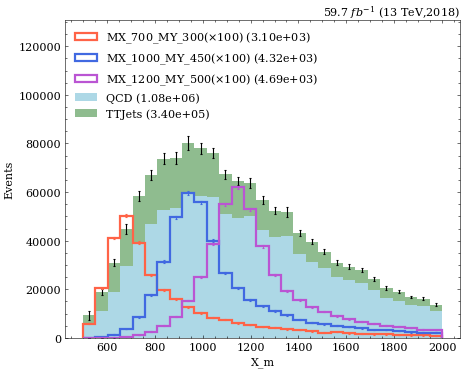

In [160]:
study.quick( 
    signal+bkg, legend=True,
    plot_scale=[100]*len(signal),
    varlist=['X_m']
)

In [161]:
signal = signal.apply(select_jet_ptcut)
bkg = bkg.apply(select_jet_ptcut)


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


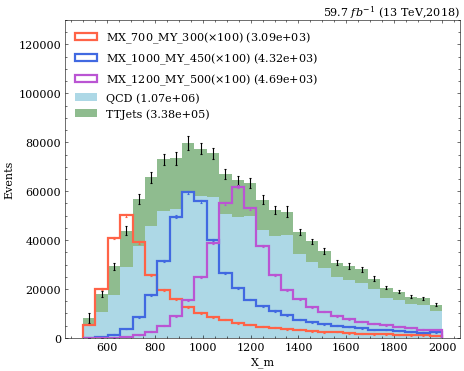

In [162]:
study.quick( 
    signal+bkg, legend=True,
    plot_scale=[100]*len(signal),
    varlist=['X_m']
)

In [163]:
signal = signal.apply(select_jet_btagmulti)
bkg = bkg.apply(select_jet_btagmulti)


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


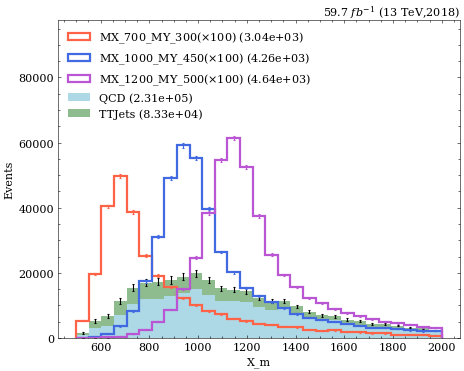

In [164]:
study.quick( 
    signal+bkg, legend=True,
    plot_scale=[100]*len(signal),
    varlist=['X_m']
)